In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mv kaggle.json ~/.kaggle/kaggle.json
! mkdir ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [11]:
! kaggle datasets download 'akmittal/quotes-dataset'
! unzip quotes-dataset.zip

  0% 0.00/3.88M [00:00<?, ?B/s]
100% 3.88M/3.88M [00:00<00:00, 129MB/s]
Archive:  quotes-dataset.zip
  inflating: quotes.json             


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras.models import Sequential
import keras.utils as ku
from keras.callbacks import EarlyStopping

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [13]:
data = pd.read_json('quotes.json')
print(data.shape)
data.head()

(48391, 5)


,Quote,Author,Tags,Popularity,Category
0,"Don't cry because it's over, smile because it ...",Dr. Seuss,"[attributed-no-source, cry, crying, experience...",0.155666,life
1,"Don't cry because it's over, smile because it ...",Dr. Seuss,"[attributed-no-source, cry, crying, experience...",0.155666,happiness
2,"I'm selfish, impatient and a little insecure. ...",Marilyn Monroe,"[attributed-no-source, best, life, love, mista...",0.129122,love
3,"I'm selfish, impatient and a little insecure. ...",Marilyn Monroe,"[attributed-no-source, best, life, love, mista...",0.129122,life
4,"I'm selfish, impatient and a little insecure. ...",Marilyn Monroe,"[attributed-no-source, best, life, love, mista...",0.129122,truth


In [14]:
# Dropping duplicates and creating a list containing all the quotes
quotes = data['Quote'].drop_duplicates()
print(f"Total Unique Quotes: {quotes.shape}")

# Considering only top 3000 quotes
quotes_filt = quotes.sample(3000)
print(f"Filtered Quotes: {quotes_filt.shape}")
all_quotes = list(quotes_filt)
all_quotes[:2]

Total Unique Quotes: (36937,)
Filtered Quotes: (3000,)


['There is only one way to happiness and that is to cease worrying about things which are beyond the power or our will.',
 'I arose like a rose, and this is how I knew I was in love. In the garden of life, I’m better off in your neighbor’s yard.']

In [15]:
# Tokeinization
tokenizer = Tokenizer()

# Function to create the sequences
def generate_sequences(corpus):
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    print(f"Total unique words in the text corpus: {total_words}")
    input_sequences = []
    for line in corpus:
        seq = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(seq)):
            ngram_seq = seq[:i+1]
            input_sequences.append(ngram_seq)
            
    return input_sequences, total_words

# Generating sequences
input_sequences, total_words = generate_sequences(all_quotes)
input_sequences[:5]

Total unique words in the text corpus: 9732


[[40, 6],
 [40, 6, 54],
 [40, 6, 54, 33],
 [40, 6, 54, 33, 85],
 [40, 6, 54, 33, 85, 2]]

In [16]:
# Generating predictors and labels from the padded sequences
def generate_input_sequence(input_sequences):
    maxlen = max([len(x) for x in input_sequences])
    input_sequences = pad_sequences(input_sequences, maxlen=maxlen)
    predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, maxlen

predictors, label, maxlen = generate_input_sequence(input_sequences)
predictors[:1], label[:1]

(array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0, 40]], dtype=int32),
 array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [17]:
# Building the model
embedding_dim = 64

def create_model(maxlen, embedding_dim, total_words):
    model = Sequential()
    model.add(layers.Embedding(total_words, embedding_dim, input_length = maxlen))
    model.add(layers.LSTM(128, dropout=0.2))
    model.add(layers.Dense(total_words, activation='softmax'))
    
    # compiling the model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

model = create_model(maxlen, embedding_dim, total_words)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 83, 64)            622848    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 9732)              1255428   
Total params: 1,977,092
Trainable params: 1,977,092
Non-trainable params: 0
_________________________________________________________________


In [18]:
predictors.shape , label.shape, maxlen

((74127, 82), (74127, 9732), 83)

In [20]:
history = model.fit(predictors, label, epochs=100, batch_size=64)

Epoch 1/100
1159/1159 [==============================] - 207s 179ms/step - loss: 6.8809
Epoch 2/100
1159/1159 [==============================] - 207s 178ms/step - loss: 6.4087
Epoch 3/100
1159/1159 [==============================] - 206s 178ms/step - loss: 6.0945
Epoch 4/100
1159/1159 [==============================] - 206s 178ms/step - loss: 5.8270
Epoch 5/100
1159/1159 [==============================] - 206s 178ms/step - loss: 5.5702
Epoch 6/100
1159/1159 [==============================] - 206s 178ms/step - loss: 5.3242
Epoch 7/100
1159/1159 [==============================] - 206s 178ms/step - loss: 5.0930
Epoch 8/100
1159/1159 [==============================] - 206s 178ms/step - loss: 4.8809
Epoch 9/100
1159/1159 [==============================] - 208s 179ms/step - loss: 4.6793
Epoch 10/100
1159/1159 [==============================] - 207s 179ms/step - loss: 4.4881
Epoch 11/100
1159/1159 [==============================] - 208s 179ms/step - loss: 4.3062
Epoch 12/100
1159/1159 [======

In [21]:
print(history.history)

{'loss': [6.880855083465576, 6.40865421295166, 6.094461441040039, 5.8270263671875, 5.5702056884765625, 5.324160099029541, 5.09303617477417, 4.880861759185791, 4.67929744720459, 4.488125324249268, 4.306235313415527, 4.13964319229126, 3.9805965423583984, 3.8343093395233154, 3.700686454772949, 3.5764689445495605, 3.4634363651275635, 3.3618950843811035, 3.264404535293579, 3.177889585494995, 3.0923104286193848, 3.022383451461792, 2.9499123096466064, 2.8830583095550537, 2.822160005569458, 2.7620487213134766, 2.7048659324645996, 2.656682252883911, 2.6051626205444336, 2.5594053268432617, 2.5213654041290283, 2.4802212715148926, 2.4374756813049316, 2.4003844261169434, 2.3663649559020996, 2.328795909881592, 2.298776388168335, 2.2695322036743164, 2.238332509994507, 2.2096505165100098, 2.1873557567596436, 2.1537389755249023, 2.1301867961883545, 2.1039328575134277, 2.080221176147461, 2.059087038040161, 2.0379135608673096, 2.0165534019470215, 1.997658610343933, 1.984391450881958, 1.962712049484253, 1

In [30]:
def generate_quote(seed_text, num_words, model, maxlen):
    
    for _ in range(num_words):
        tokens = tokenizer.texts_to_sequences([seed_text])[0]
        tokens = pad_sequences([tokens], maxlen=maxlen, padding='pre')
        
        predicted = model.predict_classes(tokens)
        
        output_word = ''
        
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text = seed_text + " " + output_word
    
    return seed_text

In [41]:
print(generate_quote("Don't cry", num_words = 2, model= model, maxlen=maxlen))

Don't cry i'm sorry


In [2]:
lossv = [6.880855083465576, 6.40865421295166, 6.094461441040039, 5.8270263671875, 5.5702056884765625, 5.324160099029541, 5.09303617477417, 4.880861759185791, 4.67929744720459, 4.488125324249268, 4.306235313415527, 4.13964319229126, 3.9805965423583984, 3.8343093395233154, 3.700686454772949, 3.5764689445495605, 3.4634363651275635, 3.3618950843811035, 3.264404535293579, 3.177889585494995, 3.0923104286193848, 3.022383451461792, 2.9499123096466064, 2.8830583095550537, 2.822160005569458, 2.7620487213134766, 2.7048659324645996, 2.656682252883911, 2.6051626205444336, 2.5594053268432617, 2.5213654041290283, 2.4802212715148926, 2.4374756813049316, 2.4003844261169434, 2.3663649559020996, 2.328795909881592, 2.298776388168335, 2.2695322036743164, 2.238332509994507, 2.2096505165100098, 2.1873557567596436, 2.1537389755249023, 2.1301867961883545, 2.1039328575134277, 2.080221176147461, 2.059087038040161, 2.0379135608673096, 2.0165534019470215, 1.997658610343933, 1.984391450881958, 1.962712049484253, 1.9441478252410889, 1.9252965450286865, 1.9076082706451416, 1.890607476234436, 1.878455638885498, 1.8652361631393433, 1.8490630388259888, 1.836296796798706, 1.8200700283050537, 1.8070342540740967, 1.7923418283462524, 1.7830779552459717, 1.7710822820663452, 1.759629726409912, 1.748358130455017, 1.734876036643982, 1.7231709957122803, 1.7161097526550293, 1.7025089263916016, 1.6925793886184692, 1.6816940307617188, 1.6735591888427734, 1.6656430959701538, 1.6558693647384644, 1.6491247415542603, 1.6379748582839966, 1.631239414215088, 1.6191731691360474, 1.6133309602737427, 1.6074256896972656, 1.5967847108840942, 1.5903266668319702, 1.5767130851745605, 1.5674548149108887, 1.5656574964523315, 1.5620230436325073, 1.5478785037994385, 1.5458009243011475, 1.541443943977356, 1.535498023033142, 1.5313421487808228, 1.5213735103607178, 1.5165318250656128, 1.500406265258789, 1.4958255290985107, 1.4921947717666626, 1.4867902994155884, 1.4803727865219116, 1.4787025451660156]

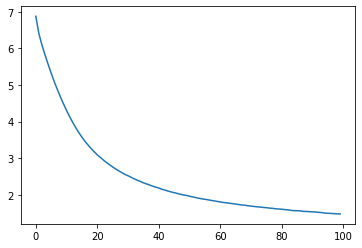

In [4]:
plt.plot(lossv)